In [106]:
import numpy as np
import matplotlib.pyplot as plt

Defino constantes y matrices necesarias

In [107]:
# LM: Podes usar un tiempo mas corto para ver mejor el transitorio (200 por ej.)
SIMULATION_TIME = 200 # [s]   


tsIMU = 0.1    # Periodo de sampleo del IMU   [s]
fsIMU = 1/tsIMU    # Coincide con la freq de sampleo del IMU   [Hz]

tsGPS = 1    # Coincide con la freq de sampleo del GPS   [Hz]
fsGPS = 1/tsGPS   # Periodo de sampleo del GPS   [s]


# Errores del acelerómetro y giróscopo
sigmaXb = 784.8e-6 * np.sqrt(fsIMU)    #[m/s^2]
sigmaYb = 784.8e-6 * np.sqrt(fsIMU)    #[m/s^2]
sigmaThetaPuntoGiroscopo = np.deg2rad(0.03 * np.sqrt(fsIMU))     #[rad / s]  

# Errores del GPS
sigmaXGps = 2.5 # [m]
sigmaYGps = 2.5 # [m]

# Errores del magnetómetro
sigmaThetaMagnetometro = np.deg2rad(0.03 * np.sqrt(fsGPS))   #[rad]

numSamples = int(SIMULATION_TIME / tsIMU)



In [108]:
A = np.array([
    [1, tsIMU, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, tsIMU, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
])

H = np.array([
    [1,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,1],
])

Q = np.array([
    [sigmaXb**2, 0, 0],
    [0, sigmaYb**2, 0],
    [0, 0, sigmaThetaPuntoGiroscopo**2]
])
    

Generar mediciones del GPS a partir de las trayectorias ideales

In [109]:
def getGPSAndMagentometerDataFromIdealPath(trayectoria_, sigmaXGps_, sigmaYGps_, sigmaThetaMagnetometro_, isCircular = False):
    # la trayectoria viene con muestras a tsIMU, y quiero devolver mediciones a tsGPS
    numMedicionesGPS = int(len(trayectoria_[0]) * tsIMU / tsGPS)

    # Crear un nuevo array para las mediciones con el tamaño adecuado
    medicionesGPSAndMagnetometer = np.zeros((3, numMedicionesGPS))
    
    # Rellenar el nuevo array con las mediciones correspondientes
    for i in range(numMedicionesGPS):
        idx = int(i * tsGPS / tsIMU)
        medicionesGPSAndMagnetometer[0][i] = trayectoria_[0][idx] + np.random.normal(0, sigmaXGps_)
        medicionesGPSAndMagnetometer[1][i] = trayectoria_[1][idx] + np.random.normal(0, sigmaYGps_)
        if(not isCircular): medicionesGPSAndMagnetometer[2][i] = trayectoria_[2][idx] + np.random.normal(0, sigmaThetaMagnetometro_)
        if(isCircular): medicionesGPSAndMagnetometer[2][i] = trayectoria_[2][idx] +  np.random.normal(0, sigmaThetaMagnetometro_)
    return medicionesGPSAndMagnetometer


Crear función que haga el procedimiento Kalman

In [110]:
""" 
    Devuelvo K, X, P
    GainKalman foreach step K [numSamples x 1]
    Estimated Status foreach step X [5x1xnumSamples]
    Estimated Cov Matrix foreach step P [5x5xnumSamples]
"""

def kalman_estimacion(uk_, xkm1, Pkm1):
    
    Bk = np.array([
        [((tsIMU**2)/2) * np.cos(xkm1[4]), -((tsIMU**2)/2)*np.sin(xkm1[4]), 0],
        [tsIMU * np.cos(xkm1[4]), -tsIMU*np.sin(xkm1[4]), 0],
        [((tsIMU**2)/2) * np.sin(xkm1[4]), ((tsIMU**2)/2)*np.cos(xkm1[4]), 0],
        [tsIMU * np.sin(xkm1[4]), tsIMU*np.cos(xkm1[4]), 0],
        [0, 0, tsIMU]
    ])       
    # Estimación a priori
    return((A@xkm1 + Bk@(uk_)), (A@Pkm1@A.T + (Bk@Q@Bk.T)))


def kalman_correccion(zk_, xkMenos_, PkMenos_, R_):
    Kk_ = PkMenos_@H.T@np.linalg.inv(H@PkMenos_@H.T + R_)
    xkEstimado_ = xkMenos_ + Kk_@((zk_) - H@xkMenos_)
    Pk_ = (np.eye(5) - Kk_@H)@PkMenos_
    return(Kk_, xkEstimado_, Pk_)


def kalman(u_, z_, initialStatus_, isGPSLossy_ = False, isMagnetometerLossy_ = False):
    MatrizKTotal = np.zeros((numSamples + 1, 5, 3))
    MatrizxTotal = np.zeros((numSamples + 1, 5))
    MatrizPTotal = np.zeros((numSamples + 1, 5, 5))

    xkm1 = initialStatus_
   
    Pkm1 = 2*np.eye(5)

    for i in range(len(u_[0])):
        # Predicción
        flagInterval = False
        xkMenos, PkMenos =  kalman_estimacion(u_[:,i], xkm1, Pkm1)

        R = np.array([
            [sigmaXGps**2, 0,0],
            [0, sigmaYGps**2, 0],
            [0, 0, sigmaThetaMagnetometro**2]
        ])
        if isGPSLossy_:
            if(i < ((3/4)*SIMULATION_TIME/tsIMU) and (i > (1/4)*SIMULATION_TIME/tsIMU)):
                flagInterval = True
                R = np.array([
                    [100000, 0,0],
                    [0, 100000, 0],
                    [0, 0, sigmaThetaMagnetometro**2]
                ])
            
            
                
        if isMagnetometerLossy_:
            
            if(i < ((3/4)*SIMULATION_TIME/tsIMU) and (i > (1/4)*SIMULATION_TIME/tsIMU)):
                flagInterval = True
                R = np.array([
                    [sigmaXGps, 0,0],
                    [0, sigmaYGps, 0],
                    [0, 0, 100000]
                ])
           
        if(i % 10 == 0):
            idx = int(i * tsIMU / tsGPS )
            if isGPSLossy_ and flagInterval == True:
                z_[0][idx] = np.random.normal(0, 100000)
                z_[1][idx] = np.random.normal(0, 100000)
            if isMagnetometerLossy_ and flagInterval == True:
                z_[2][idx] = np.random.normal(0, 100000)
            
            Kk, xkEstimado, Pk = kalman_correccion(z_[:,idx], xkMenos, PkMenos, R)
            Pkm1 = Pk
            xkm1 = xkEstimado
        else:
            xkm1 = xkMenos
            Pkm1 = PkMenos

        MatrizKTotal[i+1] = Kk  
        MatrizxTotal[i+1] = xkm1 
        MatrizPTotal[i+1] = Pkm1
    return (MatrizKTotal, MatrizxTotal, MatrizPTotal)


In [111]:
def plotieit(trayectoria_, X_):
    plt.figure(12)
    plt.plot(X_[1:,0], X_[1:,2], marker='o', color='b', label='Trayectoria estimada')
    plt.plot(trayectoria_[0], trayectoria_[1], marker='x', color='r', label='Trayectoria real', markersize=1)
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.legend()
    plt.grid(True)
    plt.show()

def plotieitErrorEvolution(trayectoria_, X_):
    plt.figure(12)
    error = np.sqrt((trayectoria_[0] - X_[1:,0])**2 + (trayectoria_[1] - X_[1:,2])**2)
    plt.plot(error, marker='o', linestyle='-', color='b', label='Error de posición')
    plt.xlabel('Tiempo')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

def plotieitCovTrazaAndModulusK(P_, K_):

    # Grafico la evolución de la traza de la matriz de covarianza
    traza_ = np.zeros(numSamples + 1)
    for i in range(numSamples + 1):
        traza_[i] = np.trace(P_[i])

    moduloGananciaKalman_ = np.zeros(numSamples + 1)
    for i in range(numSamples + 1):
        moduloGananciaKalman_[i] = np.linalg.norm(K_[i])


    print("Statzionarie value traza: ", traza_[-1])
    print("Statzionarie value ganancia: ",  moduloGananciaKalman_[-1])
    plt.figure(1089)
    plt.plot(traza_, marker='o', linestyle='-', color='b', label='Traza de la matriz de covarianza')
    plt.xlabel('Iteración')
    plt.ylabel('Traza')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(1090)
    plt.plot(moduloGananciaKalman_, marker='o', linestyle='-', color='b', label='Módulo de la ganancia Kalman')
    plt.xlabel('Iteración')
    plt.ylabel('Ganancia')
    plt.xlim(0, 200)
    plt.legend()
    plt.grid(True)
    plt.show()



Probémoslo con distintas trayectorias:

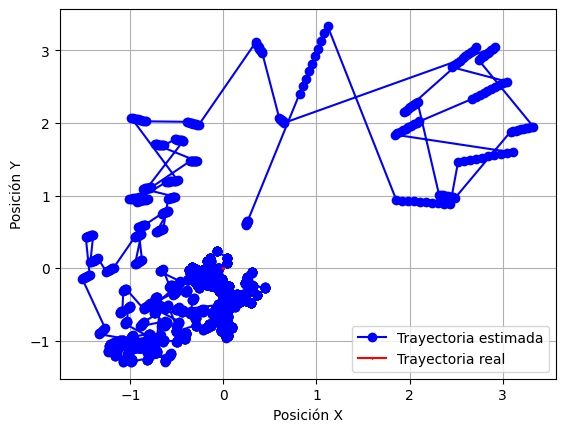

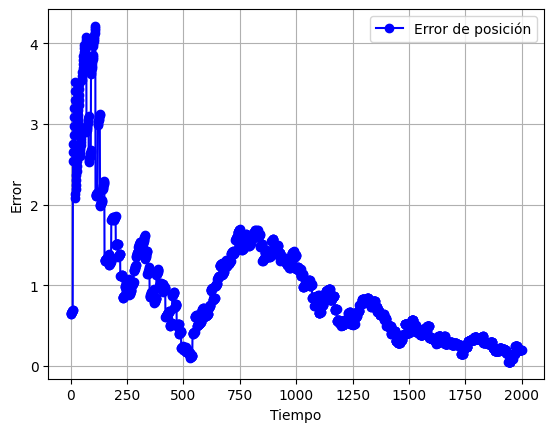

Statzionarie value traza:  0.32663207831316554
Statzionarie value ganancia:  0.6190894383069665


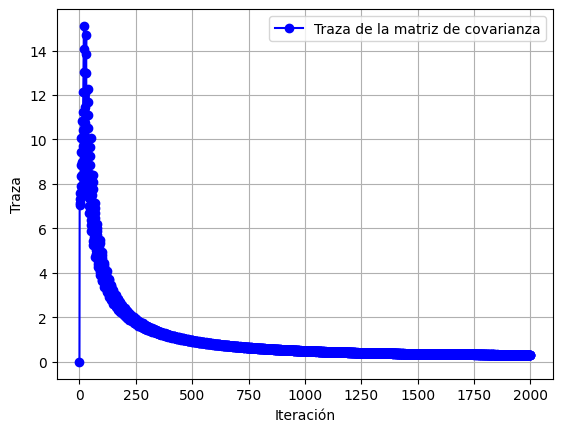

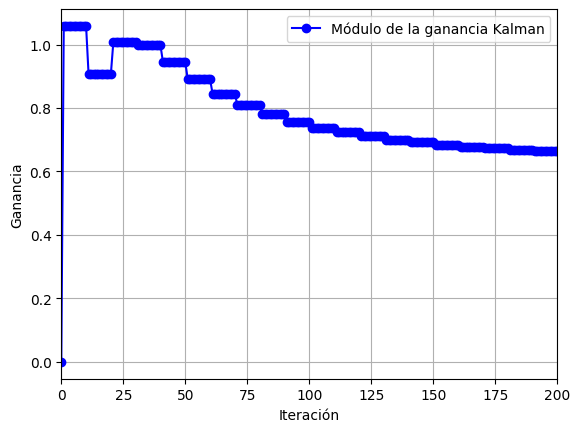

In [112]:
# Trayectoria estática
t = np.arange(0, SIMULATION_TIME, tsIMU)

rQuieto = np.array([
    np.zeros(numSamples),
    np.zeros(numSamples),
    np.zeros(numSamples)
])


z = getGPSAndMagentometerDataFromIdealPath(rQuieto, sigmaXGps, sigmaYGps, sigmaThetaMagnetometro)
u = np.array([np.zeros(numSamples), np.zeros(numSamples), np.zeros(numSamples)])
for i in range(numSamples):
    u[0][i] += np.random.normal(0, sigmaXb)
    u[1][i] += np.random.normal(0, sigmaYb)
    u[2][i] += np.random.normal(0, sigmaThetaPuntoGiroscopo)


initialStatus = np.array([0,0,0,0,0])

(K0, X0, P0) = kalman(u, z, initialStatus)
plotieit(rQuieto, X0)
plotieitErrorEvolution(rQuieto, X0)
plotieitCovTrazaAndModulusK(P0, K0)

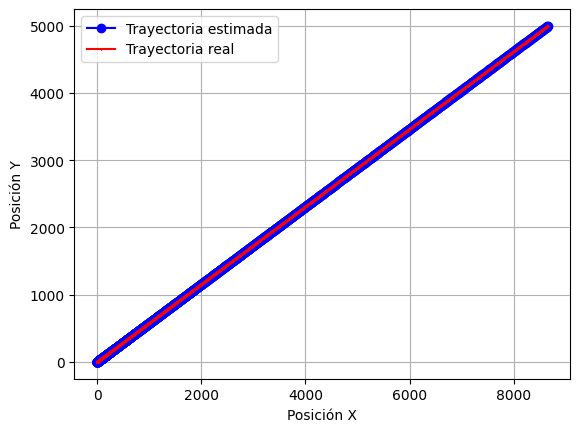

Statzionarie value traza:  0.32663207831316554
Statzionarie value ganancia:  0.6190894383069665


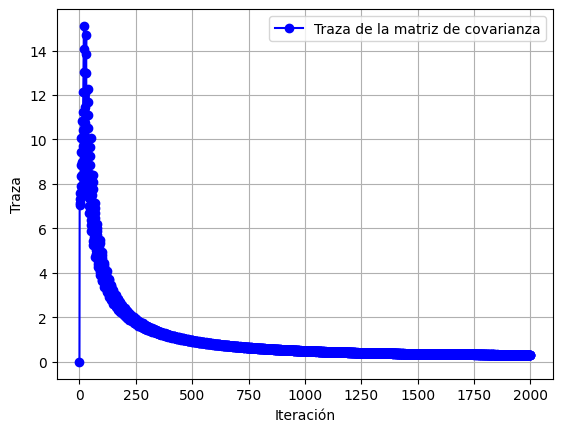

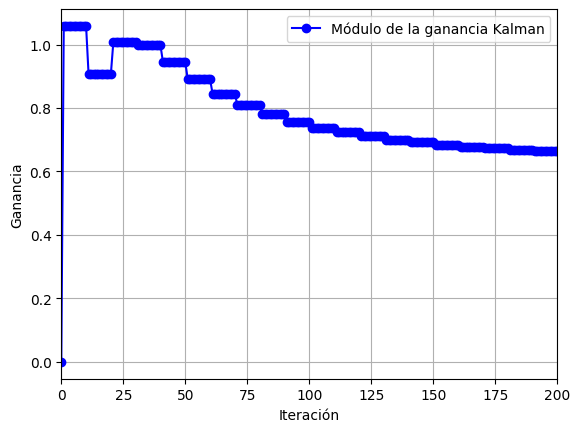

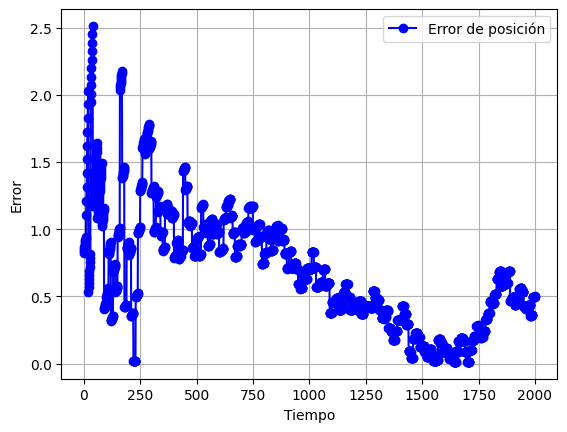

In [113]:
# Trayectoria lineal uniformemente acelerada
aceleracion= .5 # [m/s^2]   Aceleración
v0 = 0

t = np.arange(0, SIMULATION_TIME, tsIMU)
theta = np.full(numSamples, np.pi/6)

rLinealAcelerado = np.array([
    (v0*t + 0.5*aceleracion*t**2)*np.cos(theta),
    (v0*t + 0.5*aceleracion*t**2)*np.sin(theta),    
    theta
])

# Mediciones de la IMU
u = np.array([np.full(numSamples, aceleracion), np.zeros(numSamples), np.zeros(numSamples)])
for i in range(numSamples):
    u[0][i] += np.random.normal(0, sigmaXb)
    u[1][i] += np.random.normal(0, sigmaYb)
    u[2][i] += np.random.normal(0, sigmaThetaPuntoGiroscopo)


# Mediciones GPS
z = getGPSAndMagentometerDataFromIdealPath(rLinealAcelerado, sigmaXGps, sigmaYGps, sigmaThetaMagnetometro)
initialStatus = np.array([0,0,0,0,0])


(K1, X1, P1) = kalman(u, z, initialStatus, isGPSLossy_=False, isMagnetometerLossy_=False)
plotieit(rLinealAcelerado, X1)
plotieitCovTrazaAndModulusK(P1, K1)
plotieitErrorEvolution(rLinealAcelerado, X1)


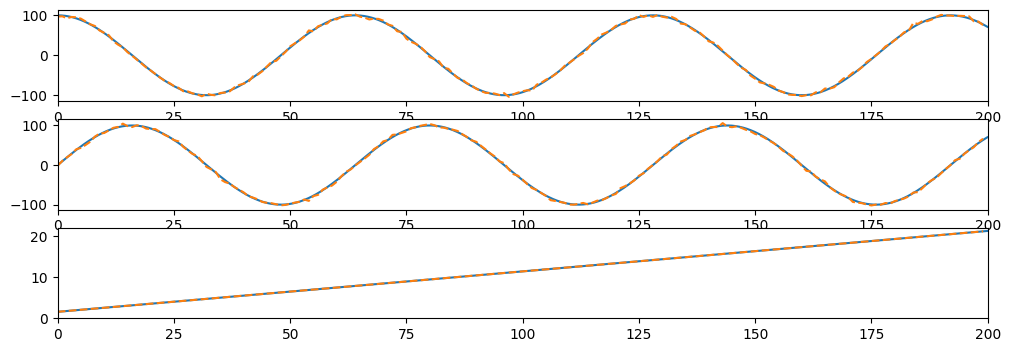

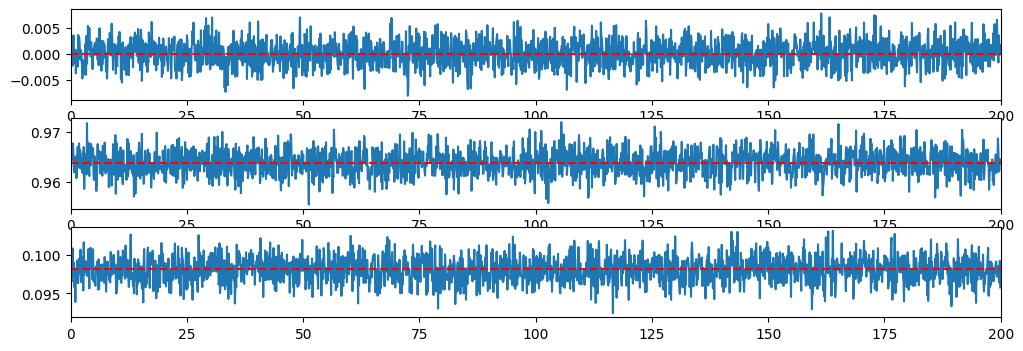

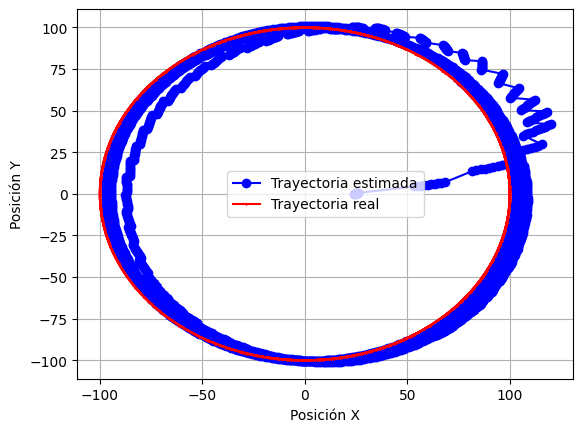

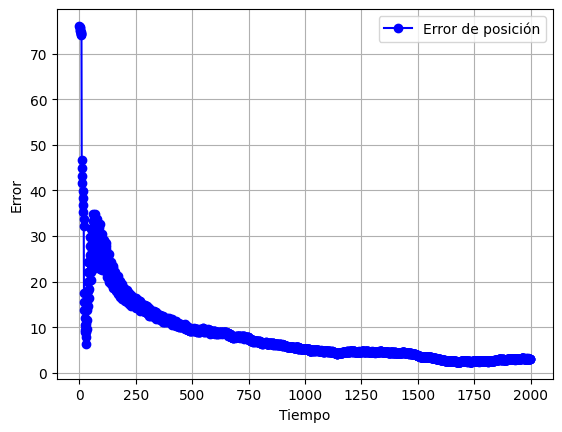

Statzionarie value traza:  0.32663207831316554
Statzionarie value ganancia:  0.6190894383069665


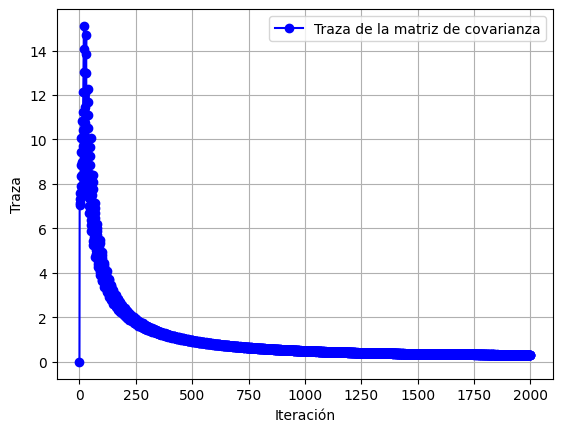

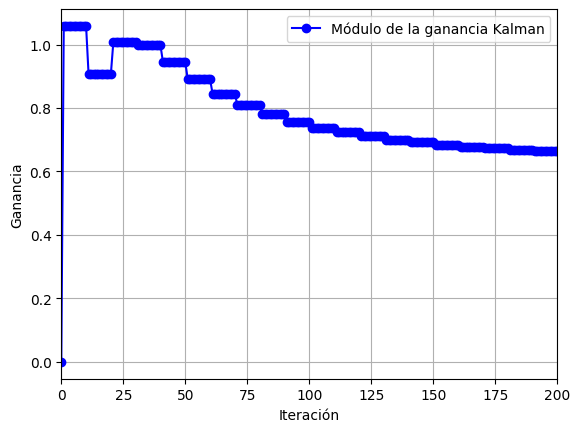

In [114]:
# Trayectoria circular
w = np.pi/32 # [rad/s]   Velocidad angular
r = 100 # [m]   Radio de la circunferencia

t = np.arange(0, SIMULATION_TIME, tsIMU)

theta0 = np.pi/2
theta = theta0 + w*t
alpha = theta - np.pi/2

rCircular = np.array([
    r*np.cos(alpha),
    r*np.sin(alpha),
    theta
])


# Mediciones de la IMU
u = np.array([np.full(numSamples, 0), np.full(numSamples, w**2*r), np.full(numSamples, w)])
for i in range(numSamples):
    u[0][i] += np.random.normal(0, sigmaXb)
    u[1][i] += np.random.normal(0, sigmaYb)
    u[2][i] += np.random.normal(0, sigmaThetaPuntoGiroscopo)


# Mediciones GPS
z = getGPSAndMagentometerDataFromIdealPath(rCircular, sigmaXGps, sigmaYGps, sigmaThetaMagnetometro, isCircular=False) # Le dejo el false porque el theta ya esta bien puesto

# Condición inicial real
#initialStatus = rCircular[0,0], 0 ,rCircular[1,0], w*r, theta[0]
# Condición inicial aleatoria
initialStatus = np.random.rand(5)



# Vemos las mediciones de GPS y Magnetometro
plt.figure(figsize=(12,4))
plt.subplot(3,1,1)
plt.plot(t, rCircular[0])
plt.plot(t[::10], z[0], "--")
plt.xlim(0,200)
plt.subplot(3,1,2)
plt.plot(t, rCircular[1])
plt.plot(t[::10], z[1], "--")
plt.xlim(0,200)
plt.subplot(3,1,3)
plt.plot(t, rCircular[2])
plt.plot(t[::10], z[2], "--")
plt.xlim(0,200)
plt.ylim(0,7*np.pi)

# Veamos las de la IMU
plt.figure(figsize=(12,4))
plt.subplot(3,1,1)
plt.plot(t, u[0])
plt.axhline(0, ls="--", c="r")
plt.xlim(0,200)
plt.subplot(3,1,2)
plt.plot(t, u[1])
plt.axhline(w**2*r, ls="--", c="r")
plt.xlim(0,200)
plt.subplot(3,1,3)
plt.plot(t, u[2])
plt.axhline(w, ls="--", c="r")
plt.xlim(0,200)

(K2, X2, P2) = kalman(u, z, initialStatus, isGPSLossy_=False)
plotieit(rCircular, X2)
plotieitErrorEvolution(rCircular, X2)
plotieitCovTrazaAndModulusK(P2, K2)


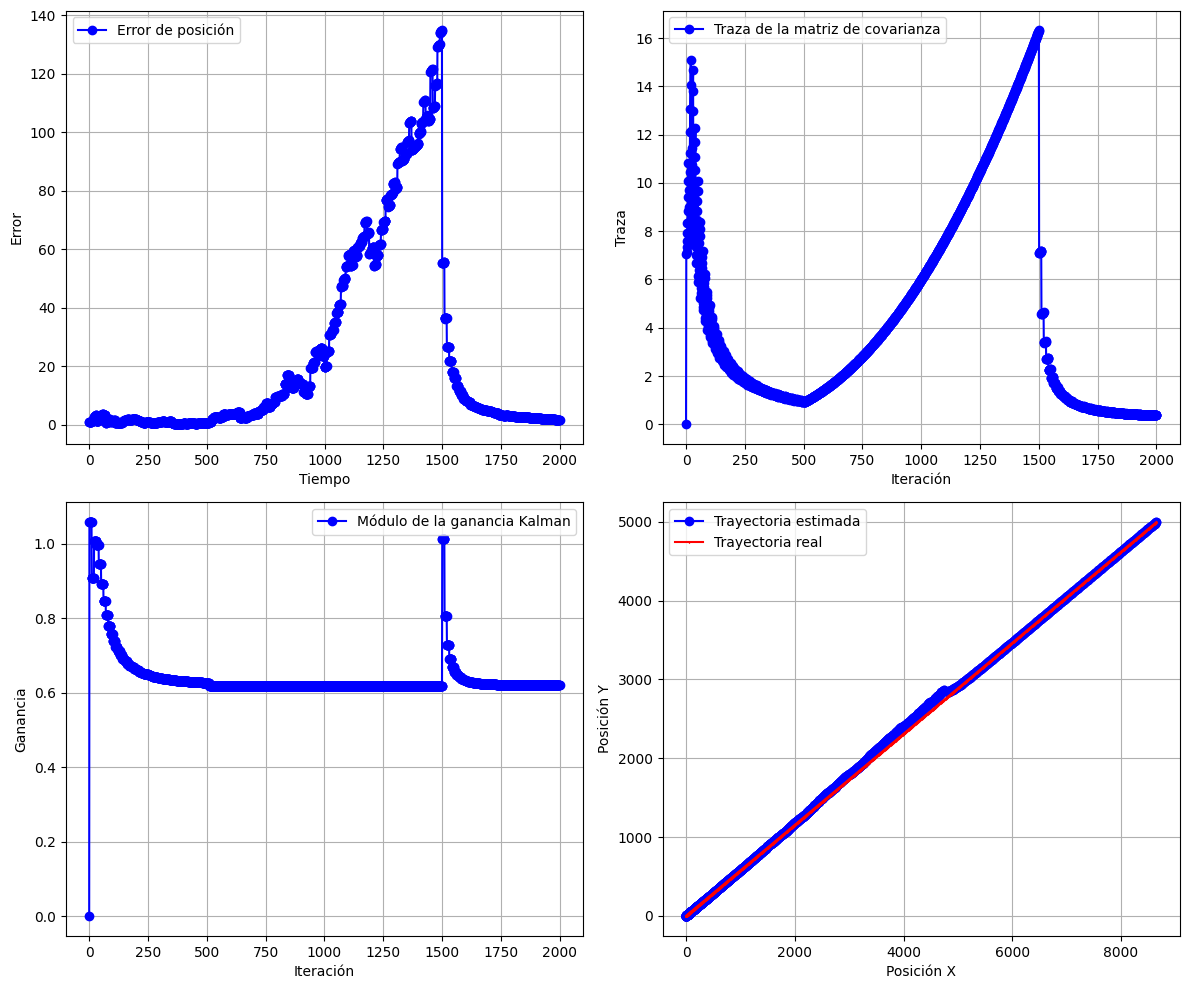

In [115]:
""" Ploteemos en una sola figura el error de posición, 
la evolución de la covarianza y de la ganancia, y la trayectoria
para el caso lineal, con GPS Lossy"""


# Mediciones de la IMU
u = np.array([np.full(numSamples, aceleracion), np.zeros(numSamples), np.zeros(numSamples)])
for i in range(numSamples):
    u[0][i] += np.random.normal(0, sigmaXb)
    u[1][i] += np.random.normal(0, sigmaYb)
    u[2][i] += np.random.normal(0, sigmaThetaPuntoGiroscopo)


# Mediciones GPS
z = getGPSAndMagentometerDataFromIdealPath(rLinealAcelerado, sigmaXGps, sigmaYGps, sigmaThetaMagnetometro)
initialStatus = np.array([0,0,0,0,0])
(KGPSLossy, XGPSLossy, PGPSLossy) = kalman(u, z, initialStatus, isGPSLossy_=True, isMagnetometerLossy_=False)


plt.figure(figsize=(12, 10))

# Error de posición
plt.subplot(2, 2, 1)
error = np.sqrt((rLinealAcelerado[0] - XGPSLossy[1:, 0])**2 + (rLinealAcelerado[1] - XGPSLossy[1:, 2])**2)
plt.plot(error, marker='o', linestyle='-', color='b', label='Error de posición')
plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Traza de la matriz de covarianza
plt.subplot(2, 2, 2)
traza_ = np.zeros(numSamples + 1)
for i in range(numSamples + 1):
    traza_[i] = np.trace(PGPSLossy[i])
plt.plot(traza_, marker='o', linestyle='-', color='b', label='Traza de la matriz de covarianza')
plt.xlabel('Iteración')
plt.ylabel('Traza')
plt.legend()
plt.grid(True)

# Evolución de la ganancia de Kalman
plt.subplot(2, 2, 3)
moduloGananciaKalman_ = np.zeros(numSamples + 1)
for i in range(numSamples + 1):
    moduloGananciaKalman_[i] = np.linalg.norm(KGPSLossy[i])
plt.plot(moduloGananciaKalman_, marker='o', linestyle='-', color='b', label='Módulo de la ganancia Kalman')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.grid(True)

# Trayectoria
plt.subplot(2, 2, 4)
plt.plot(XGPSLossy[1:, 0], XGPSLossy[1:, 2], marker='o', color='b', label='Trayectoria estimada')
plt.plot(rLinealAcelerado[0], rLinealAcelerado[1], marker='x', color='r', label='Trayectoria real', markersize=1)
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

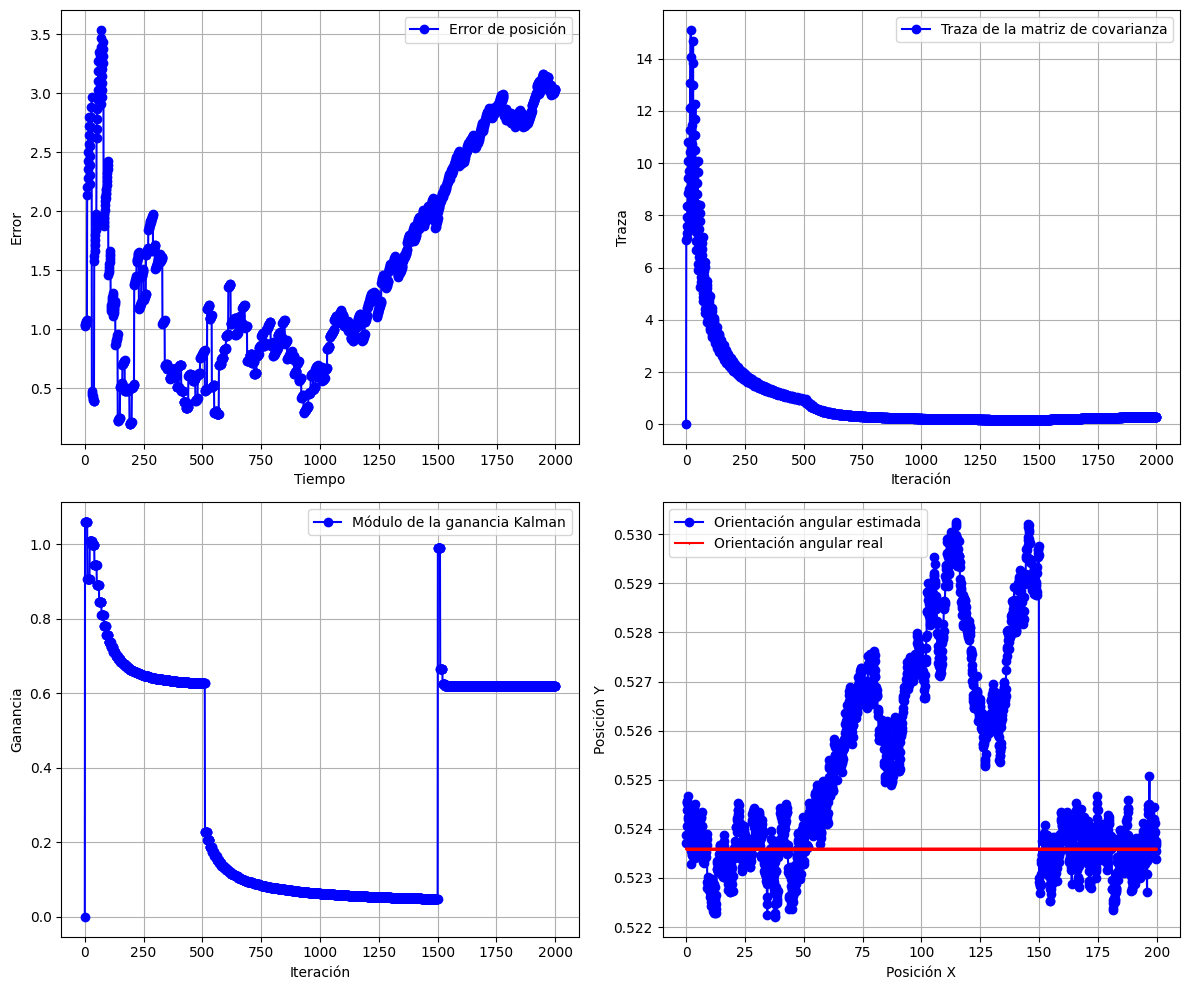

In [116]:
# Ahora lo mismo, pero para MagnetometerLossy
""" Ploteemos en una sola figura el error de posición, 
la evolución de la covarianza y de la ganancia, y la trayectoria
para el caso lineal, con Magnetometer Lossy"""


# Mediciones de la IMU
u = np.array([np.full(numSamples, aceleracion), np.zeros(numSamples), np.zeros(numSamples)])
for i in range(numSamples):
    u[0][i] += np.random.normal(0, sigmaXb)
    u[1][i] += np.random.normal(0, sigmaYb)
    u[2][i] += np.random.normal(0, sigmaThetaPuntoGiroscopo)


# Mediciones GPS
z = getGPSAndMagentometerDataFromIdealPath(rLinealAcelerado, sigmaXGps, sigmaYGps, sigmaThetaMagnetometro)
initialStatus = np.array([0,0,0,0,0])
(KMagnetometerLossy, XMagnetometerLossy, PMagnetometerLossy) = kalman(u, z, initialStatus, isGPSLossy_=False, isMagnetometerLossy_=True)


plt.figure(figsize=(12, 10))

# Error de posición
plt.subplot(2, 2, 1)
error = np.sqrt((rLinealAcelerado[0] - XMagnetometerLossy[1:, 0])**2 + (rLinealAcelerado[1] - XMagnetometerLossy[1:, 2])**2)
plt.plot(error, marker='o', linestyle='-', color='b', label='Error de posición')
plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Traza de la matriz de covarianza
plt.subplot(2, 2, 2)
traza_ = np.zeros(numSamples + 1)
for i in range(numSamples + 1):
    traza_[i] = np.trace(PMagnetometerLossy[i])
plt.plot(traza_, marker='o', linestyle='-', color='b', label='Traza de la matriz de covarianza')
plt.xlabel('Iteración')
plt.ylabel('Traza')
plt.legend()
plt.grid(True)

# Evolución de la ganancia de Kalman
plt.subplot(2, 2, 3)
moduloGananciaKalman_ = np.zeros(numSamples + 1)
for i in range(numSamples + 1):
    moduloGananciaKalman_[i] = np.linalg.norm(KMagnetometerLossy[i])
plt.plot(moduloGananciaKalman_, marker='o', linestyle='-', color='b', label='Módulo de la ganancia Kalman')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.grid(True)

# Trayectoria
plt.subplot(2, 2, 4)
plt.plot(t, XMagnetometerLossy[1:, 4],  marker='o', color='b', label='Orientación angular estimada')
plt.plot(t,rLinealAcelerado[2], marker='x', color='r', label='Orientación angular real', markersize=1)
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()